The purpose of Feature Extraction is to firstly turn raw, complex or messy images into meaningful information by learning patterns or information. We will also consider the different layers of our CNN. 
Lower Layer -> Detect lines, corners, and textures.
Middle Layer -> Detect parts of clothing, like zippers or buttons.
Topmost layer -> Detect whole object shapes or classes.

I will begin by convering the vector of length 784 into a 28x28 image to show how an image would look like (can remove this portion if used in EDA)

Next, I will compute statistical features such as the Mean Pixel Value, Standard Deviation, Pixel Intensity, and Edge Counts (also can remove if used in EDA)

More importantly, I will perform a Histogram of Oriented Gradients (HOG) to extract shape and edge information. 

I read online that we can can possibly use a pretrained ResNet to do Feature Extraction by removing the final classification layer but we would need to convert our greyscale MNIST dataset to RGB -> then feed this into a SVM/Random Forest?

In [19]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog

df_train = pd.read_csv("../data/fashion-mnist_train.csv")
df_test = pd.read_csv("../data/fashion-mnist_test.csv")
df_train.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(df_train.shape)
print(df_test.shape)

(60000, 785)
(10000, 785)


Train: 60000 rows of 1 label + 784 pixels to be converted into a 28x28 image
Test: 10000 rows of 1 label + 784 pixels to be converted into a 28x28 image

In [9]:
fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

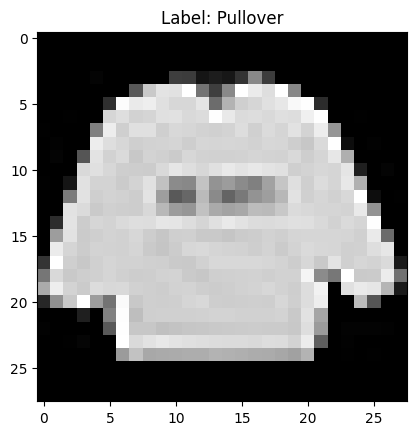

In [ ]:
image = df_train.iloc[0, 1:].to_numpy().reshape(28, 28) # Reshape only 1 image into 28x28 pixels
image_label = fashion_mnist_labels[df_train.iloc[0, 0]]

plt.imshow(image, cmap='gray')
plt.title(f"Label: {image_label}")
plt.show()

In [12]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        fd = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
        hog_features.append(fd)
    return np.array(hog_features)

In [15]:
# Extract all pixel values (drop label column)
X_train_raw = df_train.iloc[:, 1:].values  # feature shape (60000rows, 784 col)
y_train = df_train.iloc[:, 0].values       # label shape (60000rows,1 col)


X_train_images = X_train_raw.reshape(-1, 28, 28) # Reshape all rows to (28, 28)


X_train_images = X_train_images / 255.0 # Normalize

# Extract HOG features from first 1000 images (for speed)
X_hog = extract_hog_features(X_train_images[:1000])
# X_hog = extract_hog_features(X_train_images)  for full dataset
y_hog = y_train[:1000]

print("Shape of HOG feature matrix:", X_hog.shape)


Shape of HOG feature matrix: (1000, 1296)


We used the first 1000 images of the dataset to train our HOG to extract important features, hence the 1000 rows of 1296 columns (flat vector). The features in X_hog are not images anymore, but some abstract numerical representation of gradient directions and edge strengths. We can try visualising it using:

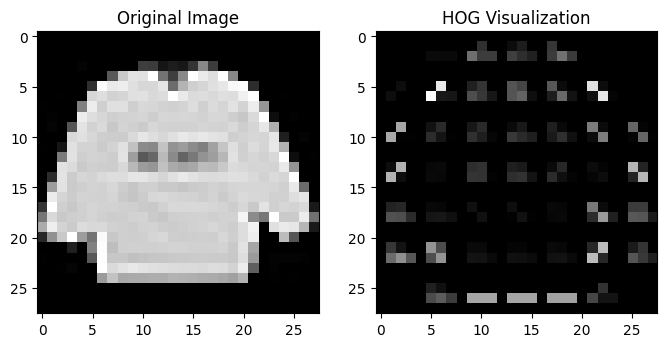

In [ ]:
from skimage import exposure


image = df_train.iloc[0, 1:].values.reshape(28, 28) / 255.0 # Recreate the first image from training data and normalise (optional)

# Get both the HOG features and visualization
fd, hog_image = hog(image,
                    orientations=9,
                    pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2),
                    block_norm='L2-Hys',
                    visualize=True)


hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) # Rescale image

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title("HOG Visualization")

plt.show()

On the right image:
Bright spots represent a sharp gradient/edge in the original image (strong edge directions)
Dark spots mean there isn't really a change in gradient/flat.

BUT textures are not captured, smaller features like buttons or zippers are also not captured for the middle layer.

Next, I will use SIFT to extract key structures like corners and blobs, focusing on small patterns/details as keypoints. SIFT is also very robust to noise, rotation and zoom. Very good for analysing local parts.

I will
1. Use inbuilt SIFT functions to detect key points and descriptors within the SIFT function
2. Visualise SIFT by comparing to the original 28x28 greyscale image again

In [20]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    all_features = []

    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            # Take mean of all descriptors in this image
            feature = np.mean(des, axis=0)
        else:
            # No keypoints found; use zeros
            feature = np.zeros(128)
        all_features.append(feature)

    return np.array(all_features)

In [ ]:
# Implement SIFT extraction on first 1000 images
X_raw = df_train.iloc[:1000, 1:].values.reshape(-1, 28, 28).astype(np.uint8)
y = df_train.iloc[:1000, 0].values

X_sift = extract_sift_features(X_raw)
print("Shape of SIFT feature matrix:", X_sift.shape) 

Shape of SIFT feature matrix: (1000, 128)


This represents the 128-dimensional feature vector for each keypoint in each image for the first 1000 rows/images.

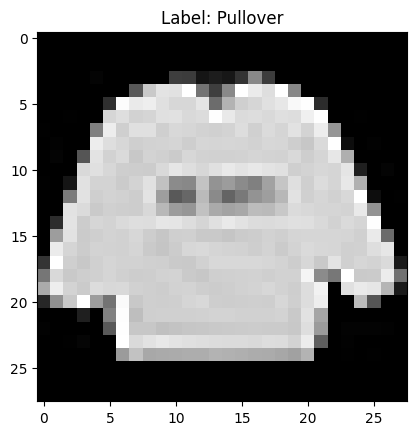

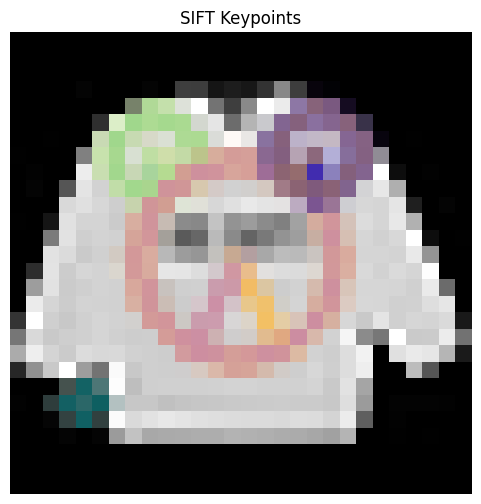

In [ ]:
# Show first image and label
image = df_train.iloc[0, 1:].values.reshape(28, 28).astype(np.uint8)
label = df_train.iloc[0, 0]

image = X_raw[0] # Select the first image as an example
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(image, None) # Detect keypoints and descriptors

# Draw keypoints on the image
image_with_kp = cv2.drawKeypoints(
    image, 
    keypoints, 
    None, 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.imshow(image, cmap='gray')
plt.title(f"Label: {image_label}")
plt.show()

# Show the result of SIFT
plt.figure(figsize=(6, 6))
plt.imshow(image_with_kp, cmap='gray')
plt.title("SIFT Keypoints")
plt.axis('off')
plt.show()